# Advanced Lane Finding

Detect lane lines and its curvature

## Initial imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from os import listdir
%matplotlib inline

## 1. Camera Calibration

List the images we have to calibrate the camera

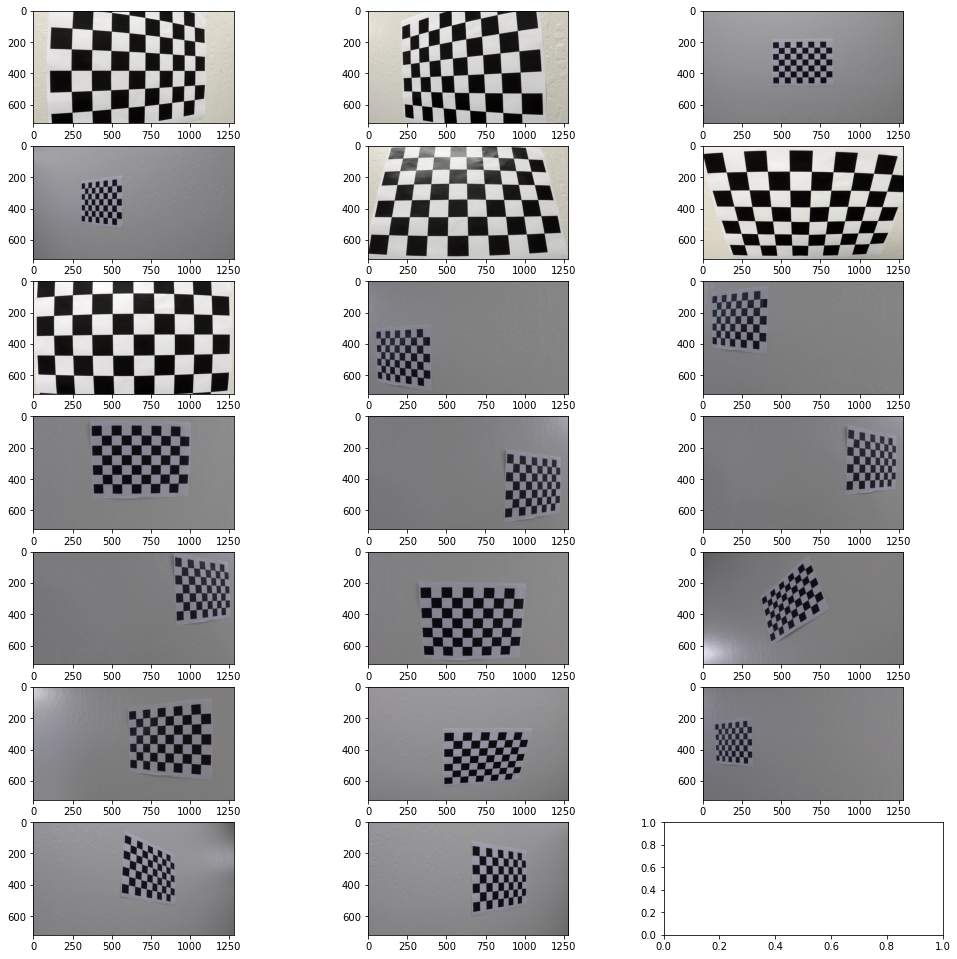

In [2]:
# Get the the images in the directory
CAMERA_CAL_DIR = './camera_cal/'
calibration_img_path_list = listdir(CAMERA_CAL_DIR)
calibration_img_path_list = [CAMERA_CAL_DIR + path for path in calibration_img_path_list]
calibration_img_list = []

# This logic is only to show all the images in rows and columns
AMOUNT_OF_COLUMNS = 3
amount_of_rows = len(calibration_img_path_list) // AMOUNT_OF_COLUMNS + 1
f, axarr = plt.subplots(amount_of_rows,3)
f.set_figheight(17)
f.set_figwidth(17)

row_counter, column_counter = 0, 0
for img_path in calibration_img_path_list:
    img = mpimg.imread(img_path)
    calibration_img_list.append(img)
    axarr[row_counter,column_counter].imshow(img)
    column_counter += 1
    if column_counter == AMOUNT_OF_COLUMNS:
        column_counter = 0
        row_counter += 1

As you can see in the images there are 6x9 corners, so we'll try to find them

In [3]:
CORNERS_X = 9
CORNERS_Y = 6

objp = np.zeros((CORNERS_X * CORNERS_Y, 3), np.float32)
objp[:,:2] = np.mgrid[0:CORNERS_X, 0:CORNERS_Y].T.reshape(-1,2)

corners_img_list = []
imgpoints = []
objpoints = []
for img in calibration_img_list:
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_img, (CORNERS_X, CORNERS_Y), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        corners_img = cv2.drawChessboardCorners(img, (CORNERS_X, CORNERS_Y), corners, ret)
        corners_img_list.append(corners_img)
    else:
        print('Not found')

Not found
Not found
Not found


There are 3 images that don't show all the corners because the picture is cut

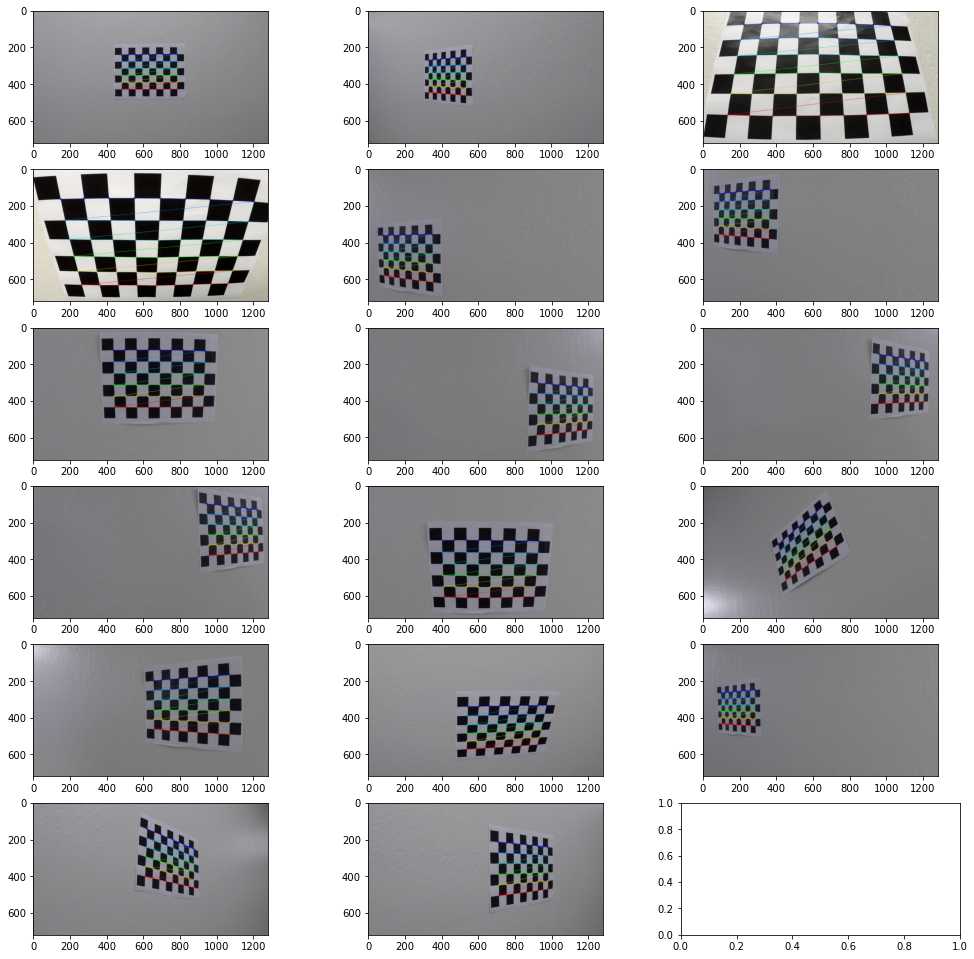

In [4]:
amount_of_rows = len(corners_img_list) // AMOUNT_OF_COLUMNS + 1
f, axarr = plt.subplots(amount_of_rows,3)
f.set_figheight(17)
f.set_figwidth(17)

row_counter, column_counter = 0, 0

for img in corners_img_list:
    axarr[row_counter,column_counter].imshow(img)
    column_counter += 1
    if column_counter == AMOUNT_OF_COLUMNS:
        column_counter = 0
        row_counter += 1

Since we have the list of corners we can proceed to calibrate the camera

In [5]:
img_size = (corners_img_list[0].shape[1], corners_img_list[0].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

## 2. Undistortion

In [6]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [7]:
def show_original_vs_undistorted(target_img):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(target_img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undistort(target_img))
    ax2.set_title('Undistorted Image', fontsize=30)

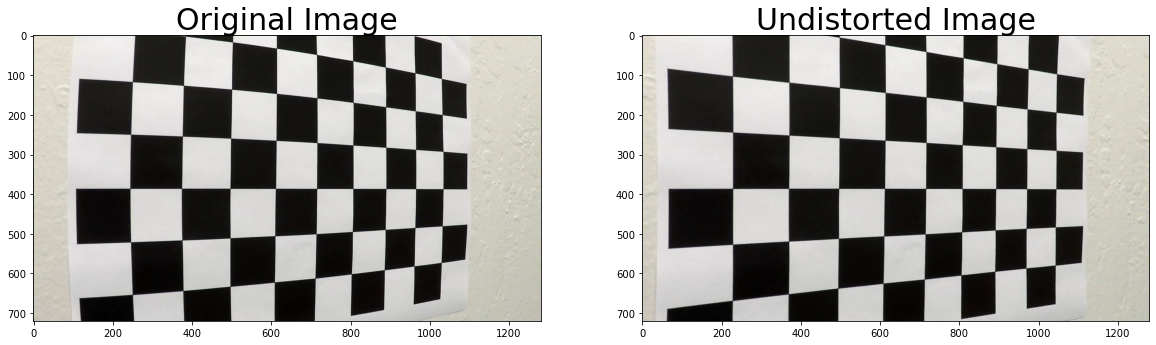

In [8]:
show_original_vs_undistorted(calibration_img_list[0])

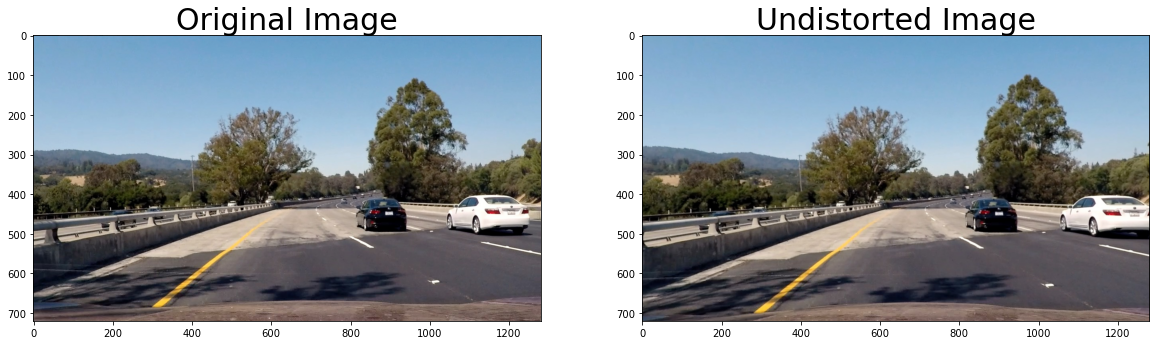

In [9]:
show_original_vs_undistorted(mpimg.imread('test_images/test4.jpg'))

## 3. Get binary image result

### Sobel X

In [10]:
def abs_sobelx_thresh(img, threshold=(0, 255), kernel=3):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F,1, 0, ksize=kernel)
    abs_sobel_x = np.absolute(sobel_x)
    scaled_img = np.uint8(255 * abs_sobel_x / np.max(abs_sobel_x))

    t_min, t_max = threshold
    binary_output = np.zeros_like(scaled_img)
    binary_output[(scaled_img > t_min) & (scaled_img <= t_max)] = 1

    return binary_output

Text(0.5, 1.0, 'Sobel x Image')

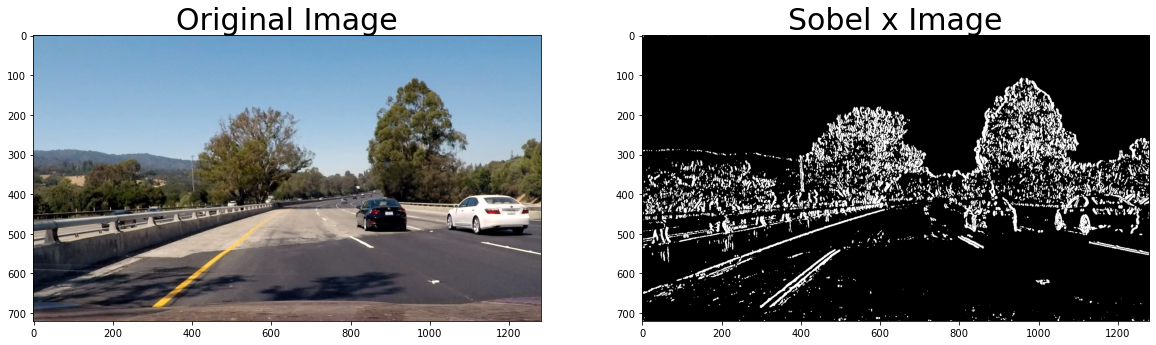

In [11]:
target_img = mpimg.imread('test_images/test4.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(target_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(abs_sobelx_thresh(target_img, (15, 255), 9), cmap='gray')
ax2.set_title('Sobel x Image', fontsize=30)

### Filter by Gradient Direction

In [12]:
def dir_threshold(img, threshold=(0, np.pi/2), sobel_kernel=3):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction, 
    absgraddir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    
    # Apply a threshold, and create a binary image result
    t_min, t_max = threshold
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir > t_min) & (absgraddir <= t_max)] = 1

    return binary_output

Text(0.5, 1.0, 'Gradient direction Image')

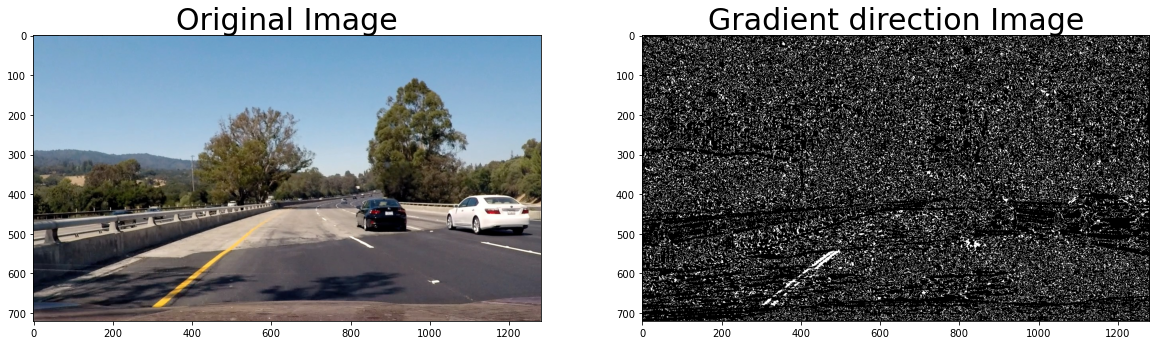

In [13]:
target_img = mpimg.imread('test_images/test4.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(target_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_threshold(target_img, (0.8, 1.1), 9), cmap='gray')
ax2.set_title('Gradient direction Image', fontsize=30)

### Filter by Gradient Magnitude

In [14]:
def mag_threshold(img, mag_thresh=(0, 255), sobel_kernel=3):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, sobel_kernel)
    
    abs_sobelxy = (sobelx ** 2 + sobely ** 2) ** 0.5
    
    scaled_sobel = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_output

Text(0.5, 1.0, 'Gradient Magnitude Image')

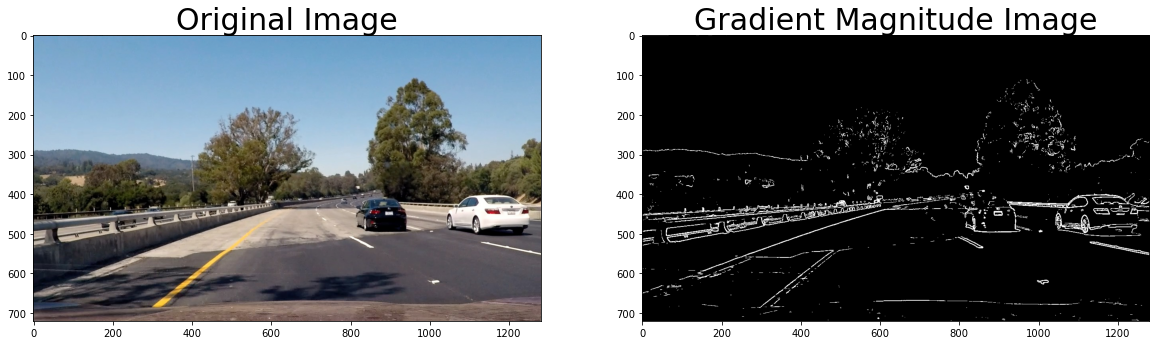

In [15]:
target_img = mpimg.imread('test_images/test4.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(target_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_threshold(target_img, (60, 250), 9), cmap='gray')
ax2.set_title('Gradient Magnitude Image', fontsize=30)

### Filter by Saturation Channel (from HLS color space)

In [16]:
def sat_channel_threshold(img, thresh=(1, 255)):
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat_channel = hls_img[:,:,2]
    
    binary_output = np.zeros_like(sat_channel)
    binary_output[(sat_channel >= thresh[0]) & (sat_channel <= thresh[1])] = 1
    
    return binary_output

Text(0.5, 1.0, 'Binary Saturation Channel')

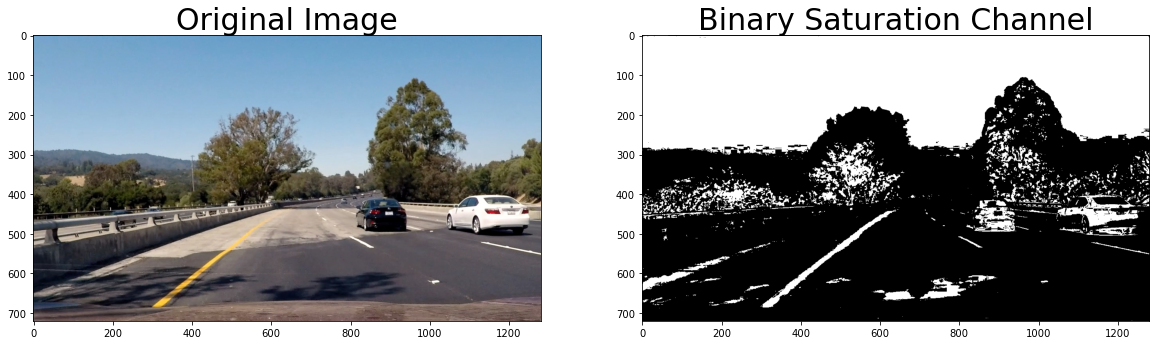

In [17]:
target_img = mpimg.imread('test_images/test4.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(target_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sat_channel_threshold(target_img, (100, 255)), cmap='gray')
ax2.set_title('Binary Saturation Channel', fontsize=30)

### Filter by Luma Channel (from YUV color space)

In [18]:
def y_channel_threshold(img, thresh=(1, 255)):
    yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    y_channel = yuv_img[:,:,0]
    
    binary_output = np.zeros_like(y_channel)
    binary_output[(y_channel >= thresh[0]) & (y_channel <= thresh[1])] = 1
    
    return binary_output

Text(0.5, 1.0, 'Binary Luma Channel')

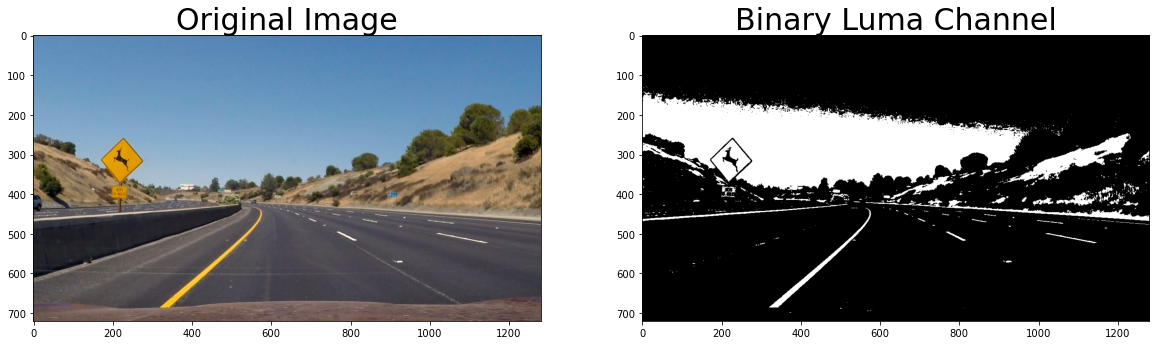

In [19]:
target_img = mpimg.imread('test_images/test2.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(target_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(y_channel_threshold(target_img, (150, 255)), cmap='gray')
ax2.set_title('Binary Luma Channel', fontsize=30)

### Combined thresholds

Since the best results were got from the use of the Saturation channel and the Sobel X, I'll proceed to combine them

Text(0.5, 1.0, 'Binary merge')

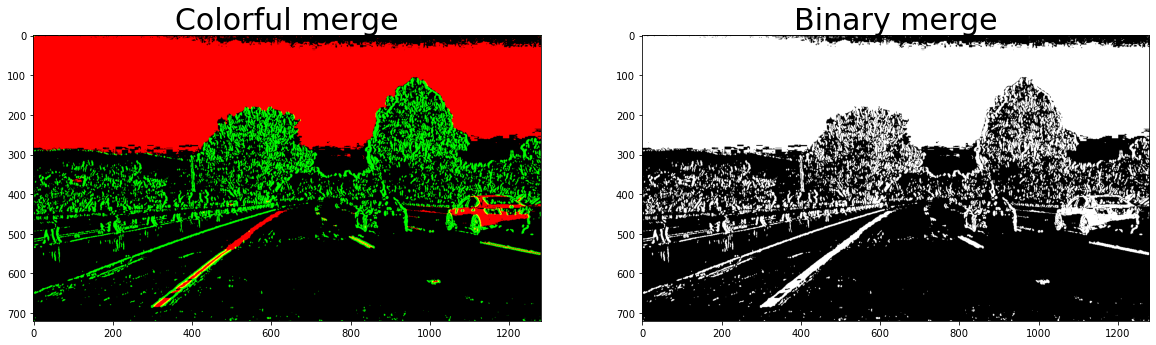

In [20]:
SOBEL_X_THRESHOLD = (15, 255)
SOBEL_X_KERNEL = 9
SAT_CHANNEL_THRESHOLD = (100, 255)
LUMA_CHANNEL_THRESHOLD = (150, 255)


def get_colorful_merge(image):
    bin_sat_img = sat_channel_threshold(image, SAT_CHANNEL_THRESHOLD)
    bin_luma_img = y_channel_threshold(image, LUMA_CHANNEL_THRESHOLD)
    binary_channels_merge = np.zeros_like(bin_sat_img)
    binary_channels_merge[(bin_sat_img == 1) & (bin_luma_img == 1)] = 1
    
    sobelx_img = abs_sobelx_thresh(image, SOBEL_X_THRESHOLD, SOBEL_X_KERNEL)
    
    return np.dstack((binary_channels_merge, sobelx_img, np.zeros_like(sobelx_img))) * 255

def get_binary(image):
    bin_sat_img = sat_channel_threshold(image, SAT_CHANNEL_THRESHOLD)
    bin_luma_img = y_channel_threshold(image, LUMA_CHANNEL_THRESHOLD)
    sobelx_img = abs_sobelx_thresh(image, SOBEL_X_THRESHOLD, SOBEL_X_KERNEL)

    binary_merge = np.zeros_like(sobelx_img)
    binary_merge[((bin_sat_img == 1) & (bin_luma_img == 1)) | (sobelx_img == 1)] = 1
    
    return binary_merge

target_img = mpimg.imread('test_images/test4.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(get_colorful_merge(target_img))
ax1.set_title('Colorful merge', fontsize=30)
ax2.imshow(get_binary(target_img), cmap='gray')
ax2.set_title('Binary merge', fontsize=30)

## 4. Apply birds-eye view transformation

### Define functions to get vertices to use in transformation

In [21]:
def get_corners_of_trapezoid(image):
    bottom_left = (140, image.shape[0])
    top_left = (image.shape[1] / 2 - 67, image.shape[0] / 2 + 100)
    top_right = (image.shape[1] / 2 + 67, image.shape[0] / 2 + 100)
    bottom_right = (image.shape[1] - 130, image.shape[0])
    
    return (bottom_left, top_left, top_right, bottom_right)

def get_corners_of_rectangle(corners_of_trapezoid):
    bottom_left, top_left, top_right, bottom_right = corners_of_trapezoid
    new_top_left = (bottom_left[0], 0)
    new_top_right = (bottom_right[0], 0)
    return (bottom_left, new_top_left, new_top_right, bottom_right)

def to_np_array(vertices):
    return np.array([[vertices[0], vertices[1], vertices[2], vertices[3]]], dtype=np.int32)

### Show vertices

Red trapezoid represents the source vertices

Green rectangle represents the destination vertices

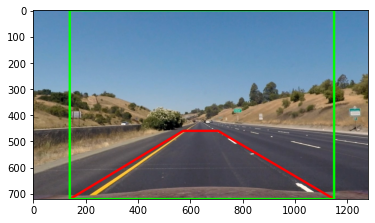

In [22]:
target_img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted_img = undistort(target_img)

corners_of_trapezoid = get_corners_of_trapezoid(undistorted_img)

# Draw trapezoid (source vertices of transformation)
cv2.polylines(undistorted_img, to_np_array(corners_of_trapezoid), True, (255, 0 , 0), thickness=8)

# Draw rectangle (destination vertices of transformation)
corners_of_rectangle = get_corners_of_rectangle(corners_of_trapezoid)
cv2.polylines(undistorted_img, to_np_array(corners_of_rectangle), True, (0, 255 , 0), thickness=8)

plt.imshow(undistorted_img)

### Create transformation functions

In [23]:
src = np.float32([corners_of_trapezoid])
dst = np.float32([corners_of_rectangle])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

### Define bird_eye function

In [24]:
def bird_eye(image, is_distorted=False, show_rectangle=False):
    if is_distorted:
        undistorted_img = undistort(image)
    else:
        undistorted_img = image

    img_size = (undistorted_img.shape[1], undistorted_img.shape[0])
    warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
    if (show_rectangle):
        cv2.polylines(warped_img, to_np_array(((185, 710), (185, 0), (1100, 0), (1100, 710))), True, (0, 255 , 0), thickness=8)
        
    return warped_img  

### Show some results

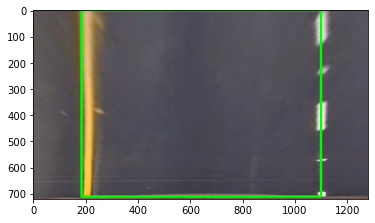

In [25]:
target_img = mpimg.imread('test_images/straight_lines1.jpg')
plt.imshow(bird_eye(target_img, True, True))

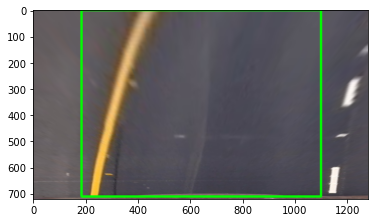

In [26]:
target_img = mpimg.imread('test_images/test3.jpg')
plt.imshow(bird_eye(target_img, True, True))

## 5. Detect lane lines

### Draw histogram with amount of pixels in axis Y

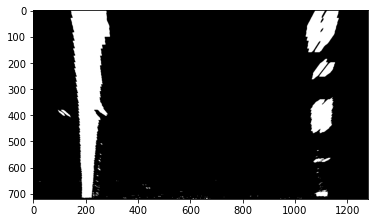

In [27]:
target_img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted_img = undistort(target_img)
binary_img = get_binary(undistorted_img)
binary_warped_img = bird_eye(binary_img)

plt.imshow(binary_warped_img, cmap='gray')

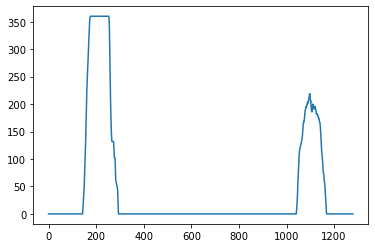

In [28]:
def get_histogram(binary_img):
    lower_half = binary_img[:binary_img.shape[0] // 2]
    return np.sum(lower_half, axis=0)

plt.plot(get_histogram(binary_warped_img))

### Find lane lines

- Use histogram to find the mean X value where are most of the pixels for both left and right lane lines
- With those initial positions, draw small windows to detect the lane pixels in those windows
- Recenter every window if the previous one had enough amount of pixels
- Return the indices of the pixels that are lane lines

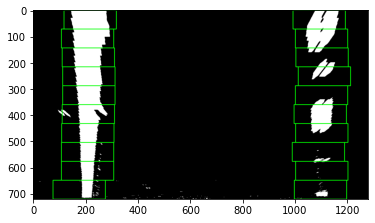

In [29]:
N_WINDOWS = 10
WINDOW_WIDTH = 100
MIN_PIX = 50

def draw_window(img, bottom_left_point, top_right_point):
    cv2.rectangle(img, bottom_left_point, top_right_point, (0,255,0), 2)
    
def build_get_nonzero_pixels_within_window(window_y_low, window_y_high, nonzerox, nonzeroy, output_img=None):
    def get_nonzero_pixels_within_window(x_current, window_width=WINDOW_WIDTH):
        # Get window's boundaries
        window_x_low = x_current - window_width
        window_x_high = x_current + window_width

        if type(output_img) is np.ndarray:
            bottom_left_point = (window_x_low, window_y_low)
            top_right_point = (window_x_high, window_y_high)
            draw_window(output_img, bottom_left_point, top_right_point)

        return (
            (nonzeroy >= window_y_low) &
            (nonzeroy < window_y_high) & 
            (nonzerox >= window_x_low) &
            (nonzerox < window_x_high)
        ).nonzero()[0]

        return nonzero_pixels_within_window
    
    return get_nonzero_pixels_within_window

def recenter_if_enough_pixels_found(indices, nonzerox, current):
    if len(indices) > MIN_PIX:
        return np.int(np.mean(nonzerox[indices]))
    else:
        return current
    
def get_best_x_base(initial_x, image_height, nonzerox, nonzeroy):
    '''
    Sometimes the initial x (which we get from the peak of the histogram) don't have enough pixels
    For those cases we can double the window's width to recenter the first x
    '''
    window_height = np.int(image_height // N_WINDOWS)
    win_y_low = image_height - window_height
    get_nonzero_pixels_within_window = build_get_nonzero_pixels_within_window(
        win_y_low,
        image_height,
        nonzerox,
        nonzeroy
    )
    indices = get_nonzero_pixels_within_window(initial_x)
    if len(indices) > MIN_PIX:
        return initial_x
    else:
        indices = get_nonzero_pixels_within_window(initial_x, WINDOW_WIDTH * 2)
        if len(indices) == 0:
            return initial_x
        return np.int(np.mean(nonzerox[indices]))
    
def find_lane_pixels(binary_warped_img):
    histogram = get_histogram(binary_warped_img)

    # Windows height based on N_WINDOWS
    img_height = binary_warped_img.shape[0]
    window_height = np.int(img_height // N_WINDOWS)

    # Identify the x and y positions of all the activated pixels in the image
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Get start points
    mid_x = binary_warped_img.shape[1] // 2
    leftx_base = np.argmax(histogram[:mid_x])
    rightx_base = np.argmax(histogram[mid_x:]) + mid_x

    leftx_current = get_best_x_base(leftx_base, img_height, nonzerox, nonzeroy)
    rightx_current = get_best_x_base(rightx_base, img_height, nonzerox, nonzeroy)
    left_lane_indices, right_lane_indices = [], []

    output_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img)) * 255

    # Step through the windows one by one
    for window in range(N_WINDOWS):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_img.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped_img.shape[0] - window * window_height

        # Build function already configured to get nonzero pixels within the window
        get_nonzero_pixels_within_window = build_get_nonzero_pixels_within_window(
            win_y_low,
            win_y_high,
            nonzerox,
            nonzeroy,
            output_img
        )

        good_left_indices = get_nonzero_pixels_within_window(leftx_current)
        good_right_indices = get_nonzero_pixels_within_window(rightx_current)

        # Append these indices to the lists
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)

        # Only recenter if we found enough pixels (we don't want to recenter if the window does not include enough pixels)
        leftx_current = recenter_if_enough_pixels_found(good_left_indices, nonzerox, leftx_current)
        rightx_current = recenter_if_enough_pixels_found(good_right_indices, nonzerox, rightx_current)
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_indices = np.concatenate(left_lane_indices)
        right_lane_indices = np.concatenate(right_lane_indices)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_indices]
    lefty = nonzeroy[left_lane_indices] 
    rightx = nonzerox[right_lane_indices]
    righty = nonzeroy[right_lane_indices]

    return leftx, lefty, rightx, righty, output_img


leftx, lefty, rightx, righty, output_img = find_lane_pixels(binary_warped_img)
plt.imshow(output_img)

### Use lane pixels to get a polynomial function that fits with those values

Since we know that the lines should be parallel, we can get the average of the coefficients to smooth any errors and keep a final result with parallel lines. We keep the original third coefficient because it's the one that indicates the offset, which we don't want to change

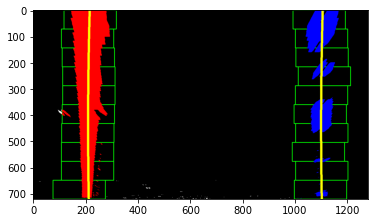

In [30]:
def get_polynomial_coefficients(leftx, lefty, rightx, righty):
    # Fit a second order polynomial for both lines
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Since the lines should be parallel we'll calculate the average between both results
    avg_a_coefficient = (left_fit[0] + right_fit[0]) / 2
    avg_b_coefficient = (left_fit[1] + right_fit[1]) / 2
    
    left_coefficients = avg_a_coefficient, avg_b_coefficient, left_fit[2]
    right_coefficients = avg_a_coefficient, avg_b_coefficient, right_fit[2]
    return left_coefficients, right_coefficients

def fit_polynomial(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial for both lines
    left_fit, right_fit = get_polynomial_coefficients(leftx, lefty, rightx, righty)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty

def build_points(x_values, y_values):
    return np.array([
        np.transpose(
            np.vstack([x_values, y_values])
        )
    ])

def highlight_detected_lines(image, leftx, lefty, rightx, righty):
    if len(image.shape) == 2:
        output_img = np.dstack((image, image, image)) * 255
    else:
        output_img = np.copy(image)

    # Colors in the left and right lane regions
    output_img[lefty, leftx] = [255, 0, 0]
    output_img[righty, rightx] = [0, 0, 255]
    
    left_fitx, right_fitx, ploty = fit_polynomial(output_img.shape, leftx, lefty, rightx, righty)

    # Plots the left and right polynomials on the lane lines
    left_points = build_points(left_fitx, ploty)
    cv2.polylines(output_img, np.int32([left_points]), False, (255,255,0), thickness= 8)
    
    right_points = build_points(right_fitx, ploty)
    cv2.polylines(output_img, np.int32([right_points]), False, (255,255,0), thickness= 8)
    
    return output_img


leftx, lefty, rightx, righty, output_img = find_lane_pixels(binary_warped_img)
plt.imshow(highlight_detected_lines(output_img, leftx, lefty, rightx, righty))

### Detect lane lines' pixels from a polynomial

Since there shouldn't be big changes between a frame and the next one, we can take advantage of having calculated a polynomial to search only in an area based on that polynomial. This is more efficient than searching for lines in the entire image for every frame

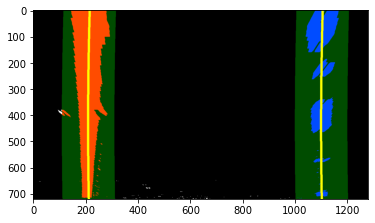

In [31]:
FUNCTION_MARGIN = 100

def filter_by_area(coefficients, nonzerox, nonzeroy):
    A, B, C = coefficients
    condition = (
        (nonzerox > (A * (nonzeroy**2) + B * nonzeroy + C - FUNCTION_MARGIN)) &
        (nonzerox < (A * (nonzeroy**2) + B * nonzeroy + C + FUNCTION_MARGIN))
    )
    return nonzerox[condition], nonzeroy[condition]

def get_area_points(x_values, y_values):
    '''
    Recast the x and y points into usable format for cv2.fillPoly()
    '''
    line_window1 = np.array([
        np.transpose(
            np.vstack([x_values - FUNCTION_MARGIN, y_values])
        )
    ])
    
    line_window2 = np.array([
        np.flipud(
            np.transpose(
                np.vstack([x_values + FUNCTION_MARGIN, y_values])
            )
        )
    ])
    
    return np.hstack((line_window1, line_window2))

def search_around_polynomial(binary_warped_img, previous_left_fit, previous_right_fit):
    # Grab activated pixels
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Get pixels in the area around the polynomial
    leftx, lefty = filter_by_area(previous_left_fit, nonzerox, nonzeroy)
    rightx, righty = filter_by_area(previous_right_fit, nonzerox, nonzeroy)
    
    return leftx, lefty, rightx, righty

def show_search_around_polynomial(binary_warped_img, previous_left_fit, previous_right_fit):
    leftx, lefty, rightx, righty = search_around_polynomial(binary_warped_img, previous_left_fit, previous_right_fit)
    
    output_img = highlight_detected_lines(binary_warped_img, leftx, lefty, rightx, righty)
    window_img = np.zeros_like(output_img)
    
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_polynomial(binary_warped_img.shape, leftx, lefty, rightx, righty)
    
    # Generate a polygon to illustrate the search window area
    left_line_area_pts = get_area_points(left_fitx, ploty)
    right_line_area_pts = get_area_points(right_fitx, ploty)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_area_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_area_pts]), (0,255, 0))
    result = cv2.addWeighted(output_img, 1, window_img, 0.3, 0)
    
    return result


sample_left_fit = np.array([-3.29734630e-05, 2.53874748e-02, 2.05904958e+02])
sample_right_fit = np.array([ 6.15096776e-05, -4.14595067e-02, 1.10698497e+03])
plt.imshow(show_search_around_polynomial(binary_warped_img, sample_left_fit, sample_right_fit))

## 6. Messure curvature

Calculate radius based on this formula: https://www.intmath.com/applications-differentiation/8-radius-curvature.php

In [32]:
def measure_curvature(coefficients, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    A, B, C = coefficients
    return ((1 + (2 * A * y_eval * ym_per_pix + B)**2)**1.5) / np.absolute(2 * A)

leftx, lefty, rightx, righty, output_img = find_lane_pixels(binary_warped_img)
left_fit, right_fit = get_polynomial_coefficients(leftx, lefty, rightx, righty)
left_fitx, right_fitx, ploty = fit_polynomial(binary_warped_img.shape, leftx, lefty, rightx, righty)

print('Radius: ', measure_curvature(left_fit, ploty))

Radius:  15810.514118484925


## 7. Draw area between lane lines

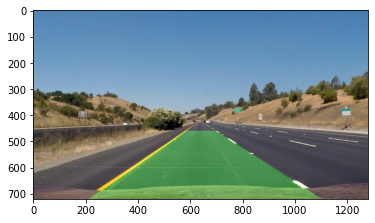

In [33]:
def draw_area(image, leftx, rightx, ploty):
    area = np.zeros_like(image)
    
    # Cast points to use with cv2.fillPoly
    left_line_pts = np.array([np.transpose(np.vstack([leftx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((left_line_pts, right_line_pts))

    # Draw area in an empty image
    cv2.fillPoly(area, np.int_([pts]), (0,255, 0))
    
    # Since the points were taken from a bird eye view, transform the image with the inverse function
    img_size = (area.shape[1], area.shape[0])
    area = cv2.warpPerspective(area, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    # Draw area on the original image and return
    return cv2.addWeighted(image, 1, area, 0.3, 0)

leftx, lefty, rightx, righty, output_img = find_lane_pixels(binary_warped_img)
left_fitx, right_fitx, ploty = fit_polynomial(binary_warped_img.shape, leftx, lefty, rightx, righty)
target_img = mpimg.imread('test_images/straight_lines1.jpg')
plt.imshow(draw_area(target_img, left_fitx, right_fitx, ploty))

## 8. Define the final pipeline

In [34]:
prev_left_fit, prev_right_fit = None, None
use_previous_values = False

def set_previous_values(use_prev, left_coeff, right_coeff):
    global use_previous_values
    use_previous_values = use_prev
    global prev_left_fit
    prev_left_fit = left_coeff
    global prev_right_fit
    prev_right_fit = right_coeff

def pipeline(image):
    undistorted_img = undistort(image)
    
    binary_img = get_binary(undistorted_img)
    
    binary_warped_img = bird_eye(binary_img)

    # TODO: Ask if previous result available
    if use_previous_values == True:
        leftx, lefty, rightx, righty = search_around_polynomial(binary_warped_img, prev_left_fit, prev_right_fit)
    else:
        leftx, lefty, rightx, righty, _ = find_lane_pixels(binary_warped_img)

    try:
        left_fitx, right_fitx, ploty = fit_polynomial(binary_warped_img.shape, leftx, lefty, rightx, righty)
        left_fit, right_fit = get_polynomial_coefficients(leftx, lefty, rightx, righty)
        set_previous_values(True, left_fit, right_fit)
    except:
        print('Failed to fit polynomial. Using last valid values')
        left_fitx, right_fitx, ploty = fit_polynomial(binary_warped_img.shape, prev_leftx, prev_lefty, prev_rightx, prev_righty)
        set_previous_values(False, None, None)
        
    
    output_img = draw_area(image, left_fitx, right_fitx, ploty)
    
    thumbnail_img = highlight_detected_lines(binary_warped_img, leftx, lefty, rightx, righty)
    output_img[100:240,1000:1200, :]= cv2.resize(thumbnail_img, (200,140))
    
    
    radius, distance = 1,1
    cv2.putText(output_img,"Curvature's radius: " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
    cv2.putText(output_img,"Distance from center: {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)

    return output_img

## 8. Apply all to a video!

In [35]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
white_output = './output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 3/1260 [00:00<01:16, 16.45it/s, now=None]

Moviepy - Building video ./output.mp4.
Moviepy - Writing video ./output.mp4



Moviepy - Done !
Moviepy - video ready ./output.mp4
CPU times: user 31min 29s, sys: 4min 5s, total: 35min 34s
Wall time: 2min 36s
